# Panic Project (DHLAB) - Multiclass Classification PyCaret Model for Panic Severity Prediction

author:  `@cyshin971`  

date:    `2025-06-25`  

version: `2-0`

In [1]:
version = "2-0"

# 📚 | Import Libraries 

In [2]:
import config as cfg
import logging

import os
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import numpy as np
import matplotlib.pyplot as plt
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from library.pandas_utils import move_column, remove_columns, create_empty_df, read_csv, aggregate_by_column
from library.text_utils import save_as_csv
from library.json_utils import save_dict_to_file, load_dict_from_file
from library.path_utils import get_file_path
from library.matplotlib_utils import plot_histogram_of_counts

from pycaret.classification import *
import shap
from sklearn.ensemble import VotingClassifier, StackingClassifier

# ⚙️ | Settings

In [3]:
scraped_data_filename = "final_result_20250626_360_no_ffill_grw_global" # Name of the scraped data file without extension (.csv)

dbp_param = 1

# 📁 | Path Variables 

In [4]:
DATA_PATH = "./_data"
TMP_PATH = "./cys/_tmp"
OUT_PATH = "./cys/_output"

try:
	features_dict = load_dict_from_file(OUT_PATH, 'panic_features_dict')
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {get_file_path(OUT_PATH, 'panic_features_dict')}. Please run data_analysis.ipynb first.")
print(f"Loaded features dict with {len(features_dict)} keys:")
for k, v in features_dict.items():
    if k == 'preproc_version':
        preproc_version = v
    if k == 'imputation_version':
        imputation_version = v
    elif k == 'analysis_version':
        analysis_version = v
        
    else:
        print(f'{k}: {features_dict[k]}')

if scraped_data_filename is None:
	raise ValueError("scraped_data_filename not found in features_dict")

PREPROC_PATH = f"{OUT_PATH}/{scraped_data_filename}/preprocessed"
IMPUTED_PATH = f"{OUT_PATH}/{scraped_data_filename}/imputed"
ANALYSIS_PATH = f"{OUT_PATH}/{scraped_data_filename}/analysis"
OUTPUT_PATH = f"{OUT_PATH}/severity_multiclass_pycaret"

DEBUG - (json_utils.py) load_dict_from_file: Dictionary loaded successfully from C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\panic_features_dict.json


Loaded features dict with 17 keys:
scraped_data_filename: final_result_20250626_360_no_ffill_grw_global
preproc_version: 2-1
demography: ['gender', 'age', 'marriage', 'job', 'smkHx', 'drinkHx', 'suicideHx', 'suicide_need']
dailylog: ['severity', 'exercise', 'alcohol', 'coffee', 'menstruation', 'smoking', 'positive_feeling', 'negative_feeling', 'positive_E', 'negative_E', 'anxiety', 'annoying']
mood: ['positive_feeling', 'negative_feeling', 'positive_E', 'negative_E', 'anxiety', 'annoying']
dailylog_life: ['exercise', 'alcohol', 'coffee', 'menstruation', 'smoking']
lifelog: ['HR_var', 'HR_max', 'HR_mean', 'HR_hvar_mean', 'HR_acrophase', 'HR_amplitude', 'HR_mesor', 'HR_acrophase_difference', 'HR_acrophase_difference_2d', 'HR_amplitude_difference', 'HR_amplitude_difference_2d', 'HR_mesor_difference', 'HR_mesor_difference_2d', 'bandpower(0.001-0.0005Hz)', 'bandpower(0.0005-0.0001Hz)', 'bandpower(0.0001-0.00005Hz)', 'bandpower(0.00005-0.00001Hz)', 'steps', 'SLT1', 'SLT2', 'SLT3', 'SLT4', 'S

# 🌐 | Global Variables

In [5]:
class OUTPUT:
    num_classes = 3
    class_names = ['Mild', 'Moderate', 'Severe']
    
    label2name = dict(enumerate(class_names))
    name2label = {v: k for k, v in label2name.items()}
    
    plot_label2name = {
		'class_0': 'Mild',
		'class_1': 'Moderate',
		'class_2': 'Severe'
	}
    plot_name2label = {v: k for k, v in plot_label2name.items()}

    color_name2color = {
		'Mild': 'skyblue',
		'Moderate': 'orange',
		'Severe': 'lightcoral'
	}
    
    output_dict = {
		1: 'Mild',
		2: 'Mild',
		3: 'Moderate',
		4: 'Severe',
		5: 'Severe'
	}
    output_dict_inv = {v: k for k, v in output_dict.items()}

    @staticmethod
    def get_label_name(label):
        return OUTPUT.label2name[label]
    @staticmethod
    def get_label_from_name(name):
        return OUTPUT.name2label[name]

# ⚒️ | Preprocessed Data

In [6]:
pre_data = read_csv(get_file_path(IMPUTED_PATH, f'panic_pre_data_filled_{imputation_version}({scraped_data_filename}).csv'))
display(pre_data.head(3))
metadata = read_csv(get_file_path(PREPROC_PATH, f'panic_metadata_{preproc_version}({scraped_data_filename}).csv'))
display(metadata.head(3))
demography_data = read_csv(get_file_path(PREPROC_PATH, f'panic_demography_data_{preproc_version}({scraped_data_filename}).csv'))
display(demography_data.head(3))
patient_data = read_csv(get_file_path(ANALYSIS_PATH, f'panic_patient_analysis_{analysis_version}({scraped_data_filename}).csv'))
display(patient_data.head(3))

print(f"Number of Demographic Features: {len(features_dict['demography'])}")
print(f"Number of Daily Features: {len(features_dict['dailylog'])}")
print(f"Number of Life Log Features: {len(features_dict['lifelog'])}")
print(f"Number of Questionnaire Features: {len(features_dict['questionnaire'])}")

,entry_id,dataset,ID,date,PHQ_9,STAI_X2,CSM,CTQ_1,CTQ_2,CTQ_3,...,SLT1,SLT2,SLT3,SLT4,SLT5,SLT6,total_sleep,panic,severity,panic_label
0,PXPN_10006_2024-11-04,PXPN,PXPN_10006,2024-11-04,0.0000,32.0000,31.0000,11.0000,13.0000,17.0000,...,0.0000,1.0364,0.3092,3.7711,0.5618,1.2750,6.9535,0.0000,NaN,0
1,PXPN_10006_2024-11-05,PXPN,PXPN_10006,2024-11-05,0.0000,32.0000,31.0000,11.0000,13.0000,17.0000,...,0.0000,4.4667,3.6167,4.6750,0.6500,1.8500,15.2583,0.0000,NaN,0
2,PXPN_10006_2024-11-06,PXPN,PXPN_10006,2024-11-06,0.0000,32.0000,31.0000,11.0000,13.0000,17.0000,...,0.0000,0.0000,0.2000,4.0667,1.4250,1.6833,7.3750,1.0000,NaN,0


,entry_id,ID,date,dataset,dailylog_data,lifelog_data,questionnaire_data,dtype_n,panic,n_prior_data,dbp,valid_entry_3,valid_entry_2,valid_entry_1,ref_event_id,panic_label,severity
0,SYM2-1-96_2021-08-04,SYM2-1-96,2021-08-04,SYM2,0,1,0,1,0.0000,2,NaN,0,1,1,NaN,0,NaN
1,SYM2-1-96_2021-08-03,SYM2-1-96,2021-08-03,SYM2,0,1,0,1,0.0000,1,NaN,0,0,1,NaN,0,NaN
2,SYM2-1-96_2021-08-02,SYM2-1-96,2021-08-02,SYM2,0,1,0,1,0.0000,0,NaN,0,0,0,NaN,0,NaN


,ID,gender,age,marriage,job,smkHx,drinkHx,suicideHx,suicide_need
0,PXPN_10006,0,32.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000
1,PXPN_10007,1,38.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
2,PXPN_10008,0,38.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000


,ID,n_entries,n_valid_3_entries,n_valid_2_entries,n_valid_1_entries,n_panic,max_severity,min_severity,mean_severity,n_dailylog,n_lifelog,n_questionnaire,sum_dtype,mean_dtype
0,PXPN_10006,28,18,21,24,3,2.0000,1.0000,1.3333,22,28,1,51,1.8214
1,PXPN_10007,28,16,20,24,4,2.0000,1.0000,1.2500,20,28,1,49,1.7500
2,PXPN_10008,27,18,21,24,3,2.0000,1.0000,1.6667,20,27,1,48,1.7778


Number of Demographic Features: 8
Number of Daily Features: 12
Number of Life Log Features: 37
Number of Questionnaire Features: 17


# 🔄️ | Data Processing

## Filter Relevant Data

In [7]:
filtered_metadata = create_empty_df()
filtered_pre_data = create_empty_df()
proc_data_init = create_empty_df()

# Filter metadata for entries with at least dbp_param days of prior data
print(f"Found {len(metadata[metadata['panic_label'] == 1])} entries with panic label.")
proc_data_init = metadata[(metadata[f'panic_label'] == 1) &
                          (metadata[f'valid_entry_{dbp_param}'] == 1)].copy()
filtered_panic_metadata_entry_ids = proc_data_init['entry_id'].unique()
filtered_metadata = metadata[(metadata['ref_event_id'].isin(filtered_panic_metadata_entry_ids)) &
                             (metadata[f'dbp'] <= dbp_param)].copy()
print(f"Found {len(filtered_panic_metadata_entry_ids)} entries with panic label and at least {dbp_param} days of prior data.")

# Perform checks
unique_dbp = filtered_metadata['dbp'].unique()
if len(unique_dbp) != dbp_param:
	raise ValueError(f"Expected {dbp_param} unique DBP values, found {len(unique_dbp)}: {unique_dbp}")
del unique_dbp

filtered_entry_ids = filtered_metadata['entry_id'].unique()
filtered_panic_entry_ids = filtered_metadata['ref_event_id'].unique()
# Filter pre_data for entries that reference panic events with at least dbp_param days of prior data
filtered_pre_data = pre_data[pre_data['entry_id'].isin(filtered_entry_ids)].copy()

# Perform checks
if len(filtered_pre_data) != len(filtered_metadata):
	raise ValueError(f"Filtered pre_data length {len(filtered_pre_data)} does not match filtered_metadata length {len(filtered_metadata)}")
print(f"Filtered data contains {len(filtered_panic_entry_ids)} unique panic events and {len(filtered_entry_ids)} unique entry IDs.")
print(f"Filtered pre_data contains {len(filtered_pre_data['ID'].unique())} unique IDs.")
del filtered_entry_ids

# Initialize processed data with correct entries
proc_data_init = proc_data_init[features_dict['id']+features_dict['label']].copy()
print(f"Initial processed data contains {len(proc_data_init)} entries with {len(proc_data_init.columns)} columns.")
display(proc_data_init.head(5))

Found 811 entries with panic label.
Found 449 entries with panic label and at least 1 days of prior data.
Filtered data contains 449 unique panic events and 449 unique entry IDs.
Filtered pre_data contains 79 unique IDs.
Initial processed data contains 449 entries with 7 columns.


,entry_id,ID,date,dataset,panic,severity,panic_label
35,SYM2-1-96_2021-02-22,SYM2-1-96,2021-02-22,SYM2,2.0000,1.0000,1
151,SYM2-1-476_2022-05-15,SYM2-1-476,2022-05-15,SYM2,2.0000,5.0000,1
161,SYM2-1-476_2022-05-05,SYM2-1-476,2022-05-05,SYM2,2.0000,4.0000,1
1167,SYM2-1-422_2022-05-17,SYM2-1-422,2022-05-17,SYM2,2.0000,4.0000,1
1169,SYM2-1-422_2022-05-15,SYM2-1-422,2022-05-15,SYM2,2.0000,4.0000,1


## Construct Processed Data

In [8]:
proc_data_int = create_empty_df()
proc_data_int = proc_data_init.copy()

# remove 'severity' from features_dict['dailylog]
features_dict['dailylog'] = [f for f in features_dict['dailylog'] if f != 'severity']

# use demography data to add demographic features to proc_data using ID (multiple entries per ID)
proc_data_int = pd.merge(proc_data_int, demography_data, on='ID', how='left')

for i in range(1, dbp_param + 1):
    # make a dictionary of 'entry_id' : 'ref_event_id' for the current dbp
	dbp_dict = filtered_metadata[filtered_metadata['dbp'] == i].set_index('entry_id')['ref_event_id'].to_dict()
	print(f"Processing data for {i} days before panic.")

	entry_ids = dbp_dict.keys()
	filtered_pre_data_i = filtered_pre_data[filtered_pre_data['entry_id'].isin(entry_ids)].copy()
	if len(filtered_pre_data_i) != len(dbp_dict.keys()):
		raise ValueError(f"Filtered pre_data length {len(filtered_pre_data_i)} does not match filtered_metadata length {len(dbp_dict.keys())} for {i} days before panic")
  	# Update 'entry_id' in filtered_pre_data_i to the corresponding 'ref_event_id' from dbp_dict
	filtered_pre_data_i['entry_id'] = filtered_pre_data_i['entry_id'].map(dbp_dict)
	
	features_list = ['entry_id']+features_dict['dailylog']+features_dict['lifelog']
	if i == dbp_param:
		features_list += features_dict['questionnaire']
	filtered_pre_data_i = filtered_pre_data_i[features_list].copy()
	# rename ALL non-ID columns to include the suffix
	if dbp_param > 1:
		cols_to_rename = [c for c in filtered_pre_data_i.columns if c != 'entry_id']
		rename_map = {c: f"{c}({i})" for c in cols_to_rename}
		filtered_pre_data_i.rename(columns=rename_map, inplace=True)

	proc_data_int = pd.merge(proc_data_int, filtered_pre_data_i, on='entry_id', how='left', suffixes=('', f'_{i}'))

# Use OUTPUT.output_dict to map severity labels
proc_data_int['severity'] = proc_data_int['severity'].map(OUTPUT.output_dict)

display(proc_data_int.head(3))

Processing data for 1 days before panic.


,entry_id,ID,date,dataset,panic,severity,panic_label,gender,age,marriage,...,CTQ_5,KRQ,MDQ,ACQ,APPQ_1,APPQ_2,APPQ_3,BSQ,GAD_7,BRIAN
0,SYM2-1-96_2021-02-22,SYM2-1-96,2021-02-22,SYM2,2.0000,Mild,1,1,31.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,SYM2-1-476_2022-05-15,SYM2-1-476,2022-05-15,SYM2,2.0000,Severe,1,1,39.0000,0.0000,...,12.0000,102.0000,3.0000,39.0000,28.0000,44.0000,22.0000,74.0000,15.0000,65.0000
2,SYM2-1-476_2022-05-05,SYM2-1-476,2022-05-05,SYM2,2.0000,Severe,1,1,39.0000,0.0000,...,12.0000,102.0000,3.0000,39.0000,28.0000,52.0000,36.0000,74.0000,13.0000,65.0000


## 💾 | Save Processed Data

In [9]:
proc_data = create_empty_df()
proc_data = proc_data_int.copy()

r_cols = ['panic',
          'panic_label']
remove_columns(proc_data, r_cols)
move_column(proc_data, 'severity', -1)
display(proc_data.head(3))
save_as_csv(proc_data, OUTPUT_PATH, f'panic_severity_multi_proc_data_{dbp_param}days_{version}({scraped_data_filename})', index=False)

,entry_id,ID,date,dataset,gender,age,marriage,job,smkHx,drinkHx,...,KRQ,MDQ,ACQ,APPQ_1,APPQ_2,APPQ_3,BSQ,GAD_7,BRIAN,severity
0,SYM2-1-96_2021-02-22,SYM2-1-96,2021-02-22,SYM2,1,31.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Mild
1,SYM2-1-476_2022-05-15,SYM2-1-476,2022-05-15,SYM2,1,39.0000,0.0000,1.0000,1.0000,0.0000,...,102.0000,3.0000,39.0000,28.0000,44.0000,22.0000,74.0000,15.0000,65.0000,Severe
2,SYM2-1-476_2022-05-05,SYM2-1-476,2022-05-05,SYM2,1,39.0000,0.0000,1.0000,1.0000,0.0000,...,102.0000,3.0000,39.0000,28.0000,52.0000,36.0000,74.0000,13.0000,65.0000,Severe


DEBUG - (text_utils.py) save_as_csv: Saved panic_severity_multi_proc_data_1days_2-0(final_result_20250626_360_no_ffill_grw_global).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\severity_multiclass_pycaret


WindowsPath('C:/Users/cyshi/OneDrive/Documents/GitHub/Panic-Project-CYS/cys/_output/severity_multiclass_pycaret/panic_severity_multi_proc_data_1days_2-0(final_result_20250626_360_no_ffill_grw_global).csv')

## 🔍 | Processed Data Analysis

In [10]:
display(patient_data)

,ID,n_entries,n_valid_3_entries,n_valid_2_entries,n_valid_1_entries,n_panic,max_severity,min_severity,mean_severity,n_dailylog,n_lifelog,n_questionnaire,sum_dtype,mean_dtype
0,PXPN_10006,28,18,21,24,3,2.0000,1.0000,1.3333,22,28,1,51,1.8214
1,PXPN_10007,28,16,20,24,4,2.0000,1.0000,1.2500,20,28,1,49,1.7500
2,PXPN_10008,27,18,21,24,3,2.0000,1.0000,1.6667,20,27,1,48,1.7778
3,PXPN_10009,28,17,19,22,5,4.0000,1.0000,2.6000,28,28,1,57,2.0357
4,PXPN_10010,28,25,26,27,0,NaN,NaN,NaN,23,28,1,52,1.8571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,SYM2-1-478,37,30,31,33,0,NaN,NaN,NaN,9,37,1,47,1.2703
269,SYM2-1-482,3,0,0,1,0,NaN,NaN,NaN,0,3,0,3,1.0000
270,SYM2-1-62,41,12,19,29,0,NaN,NaN,NaN,1,40,0,41,1.0000
271,SYM2-1-73,1,0,0,0,1,3.0000,3.0000,3.0000,1,0,0,1,1.0000


In [11]:
agg_matrix = [
	('n_valid_panic', 'entry_id', 'count'),
	('n_mild', 'severity', lambda x: (x == 'Mild').sum()),
	('n_moderate', 'severity', lambda x: (x == 'Moderate').sum()),
	('n_severe', 'severity', lambda x: (x == 'Severe').sum()),
]

proc_data_agg = aggregate_by_column(proc_data, 'ID', agg_matrix)

# merge the relevant IDs from patient_data into proc_data_agg to get the patient data
proc_data_agg = pd.merge(proc_data_agg, patient_data, on='ID', how='left')
display(proc_data_agg.head(3))

,ID,n_valid_panic,n_mild,n_moderate,n_severe,n_entries,n_valid_3_entries,n_valid_2_entries,n_valid_1_entries,n_panic,max_severity,min_severity,mean_severity,n_dailylog,n_lifelog,n_questionnaire,sum_dtype,mean_dtype
0,PXPN_10006,3,3,0,0,28,18,21,24,3,2.0000,1.0000,1.3333,22,28,1,51,1.8214
1,PXPN_10007,4,4,0,0,28,16,20,24,4,2.0000,1.0000,1.2500,20,28,1,49,1.7500
2,PXPN_10008,3,3,0,0,27,18,21,24,3,2.0000,1.0000,1.6667,20,27,1,48,1.7778


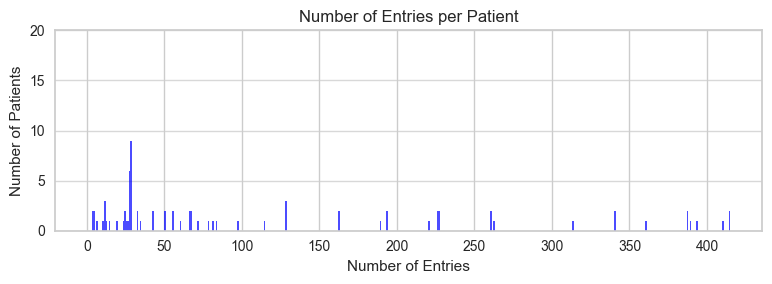

Number of patients > 100 entries: 28
Number of patients with <= 100 entries: 51


In [12]:
plot_histogram_of_counts(proc_data_agg['n_entries'],
						 title='Number of Entries per Patient', figsize=(8, 3),
						 xlabel='Number of Entries',
						 ylabel='Number of Patients', ymax=20,
       					 bins_step=50)
print(f"Number of patients > 100 entries: {len(proc_data_agg[proc_data_agg['n_entries'] > 100])}")
print(f"Number of patients with <= 100 entries: {len(proc_data_agg[proc_data_agg['n_entries'] <= 100])}")

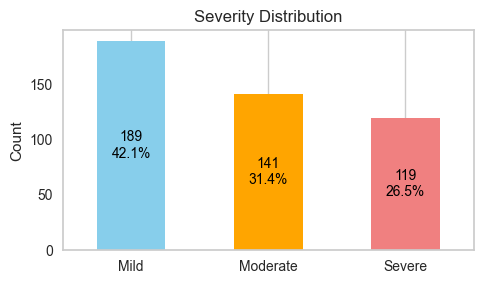

In [13]:
# make a histogram of the severity distribution
plt.figure(figsize=(5, 3))
severity_counts = proc_data['severity'].value_counts().sort_index()
total_count = severity_counts.sum()
colors = [OUTPUT.color_name2color['Mild'], OUTPUT.color_name2color['Moderate'], OUTPUT.color_name2color['Severe']]
ax = severity_counts.plot(kind='bar', color=colors)
plt.title('Severity Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Add labels with counts and percentages at the center of each bar
for p in ax.patches:
	count = p.get_height()
	percentage = f"{(count / total_count * 100):.1f}%"
	ax.annotate(f'{count}\n{percentage}',
				(p.get_x() + p.get_width() / 2., p.get_height() / 2.),
				ha='center', va='center', fontsize=10, color='black', xytext=(0, 0),
				textcoords='offset points')

# Remove the 'severity' label from the bottom
ax.set_xlabel('')

plt.tight_layout()
plt.show()

# 🤖 | Modeling

In [14]:
data = proc_data.copy()
remove_columns(data, features_dict['id'])
print(f"Processed data contains {len(data)} entries with {len(data.columns)} columns after removing ID columns.")
display(data.head(3))

Processed data contains 449 entries with 74 columns after removing ID columns.


,gender,age,marriage,job,smkHx,drinkHx,suicideHx,suicide_need,exercise,alcohol,...,KRQ,MDQ,ACQ,APPQ_1,APPQ_2,APPQ_3,BSQ,GAD_7,BRIAN,severity
0,1,31.0000,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Mild
1,1,39.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,180.0000,0.0000,...,102.0000,3.0000,39.0000,28.0000,44.0000,22.0000,74.0000,15.0000,65.0000,Severe
2,1,39.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,102.0000,3.0000,39.0000,28.0000,52.0000,36.0000,74.0000,13.0000,65.0000,Severe


In [15]:
# Initialize PyCaret setup
clf = setup(
    data=data,
    target='severity',               # replace with your target column name
    session_id=123,                  # for reproducibility
    normalize=True,                  # scale numeric features
    transformation=False,            # turn off power transformation
    train_size=0.8,                  # 80/20 split
    fold=5,                          # 5-fold cross-validation
    fold_strategy='stratifiedkfold',
    numeric_imputation='mean',
    remove_multicollinearity=True,   # for small datasets, this is often helpful
	multicollinearity_threshold=0.9, # threshold for removing multicollinear features
	# html=False,                    # do not generate HTML report (use plain-text output)
    verbose=True
)

,Description,Value
0,Session id,123
1,Target,severity
2,Target type,Multiclass
3,Target mapping,"Mild: 0, Moderate: 1, Severe: 2"
4,Original data shape,"(449, 74)"
5,Transformed data shape,"(449, 68)"
6,Transformed train set shape,"(359, 68)"
7,Transformed test set shape,"(90, 68)"
8,Numeric features,73
9,Preprocess,True


# 🚂 | Training

In [16]:
# Compare baseline models and select the best by Accuracy
best_model = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7743,0.9040,0.7743,0.7780,0.7720,0.6528,0.6564,0.4260
et,Extra Trees Classifier,0.7632,0.9225,0.7632,0.7722,0.7608,0.6369,0.6433,0.0400
lightgbm,Light Gradient Boosting Machine,0.7521,0.9046,0.7521,0.7622,0.7512,0.6197,0.6248,0.2480
gbc,Gradient Boosting Classifier,0.7327,0.0000,0.7327,0.7369,0.7314,0.5909,0.5938,0.1420
dt,Decision Tree Classifier,0.7184,0.7931,0.7184,0.7235,0.7166,0.5719,0.5758,0.4260
knn,K Neighbors Classifier,0.6491,0.8191,0.6491,0.6555,0.6450,0.4588,0.4635,0.4420
ridge,Ridge Classifier,0.6489,0.0000,0.6489,0.6501,0.6457,0.4608,0.4635,0.4300
lr,Logistic Regression,0.6461,0.0000,0.6461,0.6521,0.6464,0.4607,0.4626,0.6560
lda,Linear Discriminant Analysis,0.6433,0.0000,0.6433,0.6495,0.6424,0.4552,0.4581,0.0120
ada,Ada Boost Classifier,0.6349,0.0000,0.6349,0.6407,0.6336,0.4413,0.4442,0.0260


# 🧪 | Test

In [17]:
results = pull()  # Get the latest output table as a DataFrame
# Cross-Validation results
print("Cross-Validation Results:")
display(results)  # Jupyter display (can further style if you want)

Cross-Validation Results:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7743,0.9040,0.7743,0.7780,0.7720,0.6528,0.6564,0.4260
et,Extra Trees Classifier,0.7632,0.9225,0.7632,0.7722,0.7608,0.6369,0.6433,0.0400
lightgbm,Light Gradient Boosting Machine,0.7521,0.9046,0.7521,0.7622,0.7512,0.6197,0.6248,0.2480
gbc,Gradient Boosting Classifier,0.7327,0.0000,0.7327,0.7369,0.7314,0.5909,0.5938,0.1420
dt,Decision Tree Classifier,0.7184,0.7931,0.7184,0.7235,0.7166,0.5719,0.5758,0.4260
knn,K Neighbors Classifier,0.6491,0.8191,0.6491,0.6555,0.6450,0.4588,0.4635,0.4420
ridge,Ridge Classifier,0.6489,0.0000,0.6489,0.6501,0.6457,0.4608,0.4635,0.4300
lr,Logistic Regression,0.6461,0.0000,0.6461,0.6521,0.6464,0.4607,0.4626,0.6560
lda,Linear Discriminant Analysis,0.6433,0.0000,0.6433,0.6495,0.6424,0.4552,0.4581,0.0120
ada,Ada Boost Classifier,0.6349,0.0000,0.6349,0.6407,0.6336,0.4413,0.4442,0.0260


In [18]:
# Evaluate on hold-out set (20% test split)
holdout_results = predict_model(best_model)
print(f"Hold-out Set Results (20% test split) for {OUTPUT.num_classes} classes (test_size={len(holdout_results)}):")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7778,0.9046,0.7778,0.7834,0.7756,0.6550,0.6601


Hold-out Set Results (20% test split) for 3 classes (test_size=90):


In [19]:
spec_model_name = 'et'
if spec_model_name:
    # Create a specific model (e.g., Random Forest)
	spec_model = create_model(spec_model_name, fold=5, cross_validation=True)
	print(f"Created specific model: {spec_model_name}")

	# Evaluate the specific model
	spec_results = predict_model(spec_model)
	print(f"Specific Model Results ({spec_model_name}):")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8194,0.9419,0.8194,0.8230,0.8175,0.7197,0.7226
1,0.6806,0.8810,0.6806,0.6833,0.6806,0.5135,0.5146
2,0.7500,0.9161,0.7500,0.7703,0.7502,0.6220,0.6299
3,0.8056,0.9601,0.8056,0.8173,0.8070,0.7067,0.7107
4,0.7606,0.9133,0.7606,0.7670,0.7485,0.6226,0.6387
Mean,0.7632,0.9225,0.7632,0.7722,0.7608,0.6369,0.6433
Std,0.0489,0.0270,0.0489,0.0501,0.0491,0.0740,0.0743


Created specific model: et


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8000,0.9278,0.8000,0.8021,0.7988,0.6918,0.6939


Specific Model Results (et):


# 🔍 | Analysis

## SHAP Values

In [20]:
# Check if the best model is TreeExplainer-compatible
tree_model_ids = ['et', 'rf', 'gbc', 'lightgbm', 'dt']
tree_model_names = [
    'Extra Trees Classifier', 'Random Forest Classifier',
    'Gradient Boosting Classifier', 'Light Gradient Boosting Machine',
    'Decision Tree Classifier'
]

# Function to check compatibility by class name
def is_tree_model(model):
    model_name = model.__class__.__name__.lower()
    # Try common tree model keywords
    return any(keyword in model_name for keyword in ['forest', 'tree', 'boost', 'lightgbm'])


In [21]:
# SHAP analysis only if TreeExplainer compatible
is_compatible = is_tree_model(best_model)

if is_compatible:
    print(f"Best model ({best_model.__class__.__name__}) is compatible with SHAP TreeExplainer.")

    # Extract features (remove prediction/score columns)
    feature_cols = [col for col in holdout_results.columns if col in data.columns and col != 'severity']
    X_holdout = holdout_results[feature_cols]

    # --- Robust estimator unwrapping for ensembles ---
    model_to_explain = best_model
    base_estimator_key = None  # Track which base estimator is used
    # Unwrap only if Voting or Stacking ensemble
    if isinstance(model_to_explain, (VotingClassifier, StackingClassifier)):
        named_estimators = dict(model_to_explain.named_estimators_)
        # Try to select a tree-based model in order of preference
        for key in ['rf', 'et', 'gbc', 'lightgbm', 'dt']:
            if key in named_estimators and is_tree_model(named_estimators[key]):
                model_to_explain = named_estimators[key]
                base_estimator_key = key
                print(f"Selected base estimator '{key}' from Voting/Stacking ensemble.")
                break
        if base_estimator_key is None:
            print("Warning: No compatible tree model found in the ensemble; SHAP will use the full ensemble.")

    print("Model to explain:", type(model_to_explain))

    # Build the SHAP TreeExplainer
    explainer = shap.TreeExplainer(model_to_explain)
    shap_values = explainer.shap_values(X_holdout)

    # SHAP summary plot (for multiclass)
    # shap.summary_plot(shap_values, X_holdout)

    # Get SHAP values as DataFrame (one per class)
    shap_dfs = {}
    
    if isinstance(shap_values, list):
        # Standard SHAP output for multiclass: list of [n_samples, n_features] arrays (one per class)
        for i, class_shap in enumerate(shap_values):
            shap_dfs[f"class_{i}"] = pd.DataFrame(class_shap, columns=X_holdout.columns, index=X_holdout.index)
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        # SHAP returned shape: (n_samples, n_features, n_classes)
        n_classes = shap_values.shape[2]
        for i in range(n_classes):
            shap_dfs[f"class_{i}"] = pd.DataFrame(shap_values[:,:,i], columns=X_holdout.columns, index=X_holdout.index)
    else:
        # Binary or regression: single 2D array
        shap_dfs["shap_values"] = pd.DataFrame(shap_values, columns=X_holdout.columns, index=X_holdout.index)

    # display(shap_dfs["class_0"].head())

else:
    print(f"Best model ({best_model.__class__.__name__}) is NOT compatible with SHAP TreeExplainer.")
    print("Please select one of the following tree models for SHAP analysis: 'et', 'rf', 'gbc', 'lightgbm', 'dt'")
    print("Example:")
    print("rf_model = create_model('rf')\nrf_model = finalize_model(rf_model)\n")


Best model (RandomForestClassifier) is compatible with SHAP TreeExplainer.
Model to explain: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


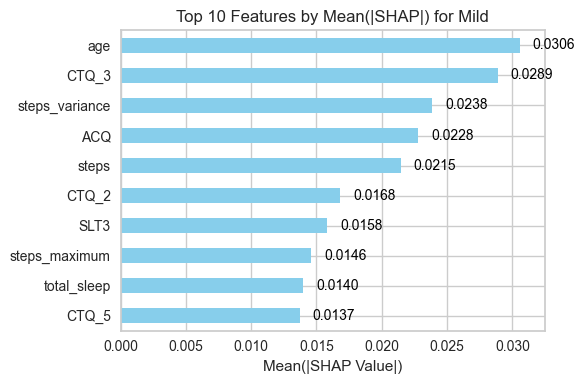

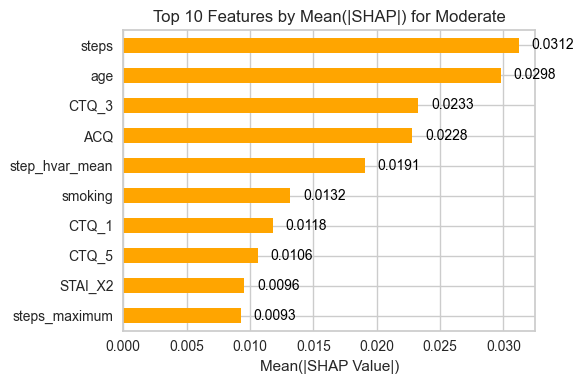

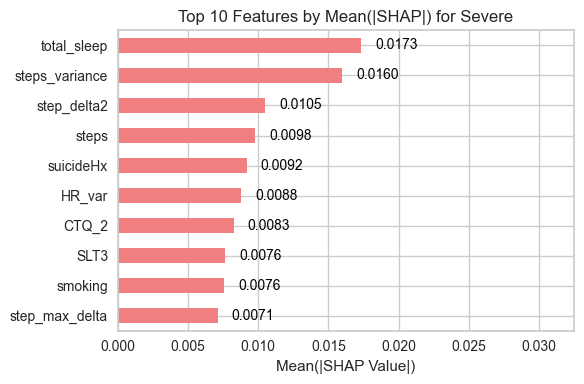

Overall Top 10 Features by Mean(|SHAP|):


,Mean(|SHAP|),Class
age,0.0302,"[Mild, Moderate]"
CTQ_3,0.0261,"[Mild, Moderate]"
ACQ,0.0228,"[Mild, Moderate]"
steps,0.0208,"[Mild, Moderate, Severe]"
steps_variance,0.0199,"[Mild, Severe]"
step_hvar_mean,0.0191,[Moderate]
total_sleep,0.0156,"[Mild, Severe]"
CTQ_2,0.0125,"[Mild, Severe]"
CTQ_5,0.0122,"[Mild, Moderate]"
steps_maximum,0.0119,"[Mild, Moderate]"


DEBUG - (text_utils.py) save_as_csv: Saved panic_severity_multi_top_features_1days_2-0(final_result_20250626_360_no_ffill_grw_global).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_tmp



Top 10 Features by GLOBAL Mean(|SHAP|) Across All Classes and Samples:


,Global Mean(|SHAP|)
Feature,
age,0.0212
steps,0.0208
CTQ_3,0.0195
ACQ,0.0164
steps_variance,0.0159
step_hvar_mean,0.0128
total_sleep,0.0122
CTQ_2,0.0113
SLT3,0.0106


DEBUG - (text_utils.py) save_as_csv: Saved panic_severity_multi_global_top_features_1days_2-0(final_result_20250626_360_no_ffill_grw_global).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_tmp


WindowsPath('C:/Users/cyshi/OneDrive/Documents/GitHub/Panic-Project-CYS/cys/_tmp/panic_severity_multi_global_top_features_1days_2-0(final_result_20250626_360_no_ffill_grw_global).csv')

In [25]:
top_n = 10  # Number of features to show

# Compute the global maximum value across all classes
global_max = max(df.abs().mean(axis=0).max() for df in shap_dfs.values()) * 1.25

top_overall_features = {}

for class_label in OUTPUT.plot_label2name.keys():
	df = shap_dfs[class_label]
	# Compute mean absolute SHAP value for each feature
	feature_importance = df.abs().mean(axis=0).sort_values(ascending=False)
	# Get top features
	top_features = feature_importance.head(top_n)
	for i, feature in enumerate(top_features.index):
		if feature not in top_overall_features:
			top_overall_features[feature] = [0, []]  # Initialize with zero and None
		top_overall_features[feature][0] += top_features[feature]
		top_overall_features[feature][1].append(OUTPUT.plot_label2name[class_label])
	
	# Bar plot
	plt.figure(figsize=(6, 4))
	colors = [OUTPUT.color_name2color[OUTPUT.plot_label2name[class_label]]] * len(top_features)
	ax = top_features[::-1].plot(kind='barh', color=colors)
	plt.title(f"Top {top_n} Features by Mean(|SHAP|) for {OUTPUT.plot_label2name[class_label]}")
	plt.xlabel("Mean(|SHAP Value|)")
	plt.xlim(0, .0325)  # Set the x-axis limit to the global maximum
	
	# Add labels with values to the right of each bar
	for p in ax.patches:
		value = f"{p.get_width():.4f}"
		ax.annotate(value,
					(p.get_width() + 0.001, p.get_y() + p.get_height() / 2),
					ha='left', va='center', fontsize=10, color='black', xytext=(0, 0),
					textcoords='offset points')
	
	plt.tight_layout()
	plt.show()

# Create a DataFrame for the overall top features
top_overall_df = pd.DataFrame.from_dict(
	{feature: {"Mean(|SHAP|)": values[0], "Class": values[1]} for feature, values in top_overall_features.items()},
	orient='index'
)
top_overall_df['Mean(|SHAP|)'] = top_overall_df.apply(
	lambda row: row['Mean(|SHAP|)'] / len(row['Class']), axis=1
)
top_overall_df = top_overall_df.sort_values(by='Mean(|SHAP|)', ascending=False)
# Display the overall top features
print(f"Overall Top {top_n} Features by Mean(|SHAP|):")
display(top_overall_df.head(top_n))
save_as_csv(top_overall_df, TMP_PATH, f'panic_severity_multi_top_features_{dbp_param}days_{version}({scraped_data_filename})', index=True)

# === GLOBAL MEAN ACROSS ALL CLASSES AND SAMPLES ===
# Stack all SHAP values (for all classes) vertically and compute mean across all samples and classes
all_abs_shap = np.vstack([df.abs().values for df in shap_dfs.values()])
global_feature_importance = pd.DataFrame({
	'Feature': X_holdout.columns,
	'Global Mean(|SHAP|)': all_abs_shap.mean(axis=0)
}).set_index('Feature')
global_top_features = global_feature_importance.sort_values(by='Global Mean(|SHAP|)', ascending=False).head(top_n)
print(f"\nTop {top_n} Features by GLOBAL Mean(|SHAP|) Across All Classes and Samples:")
display(global_top_features)
save_as_csv(global_top_features, TMP_PATH, f'panic_severity_multi_global_top_features_{dbp_param}days_{version}({scraped_data_filename})', index=True)

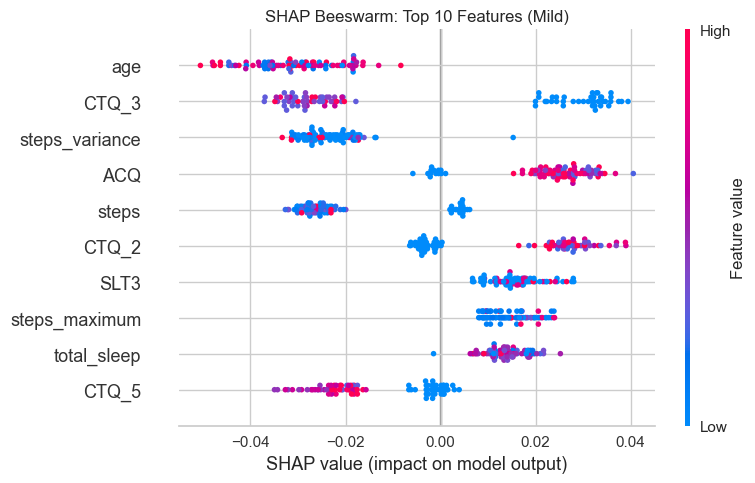

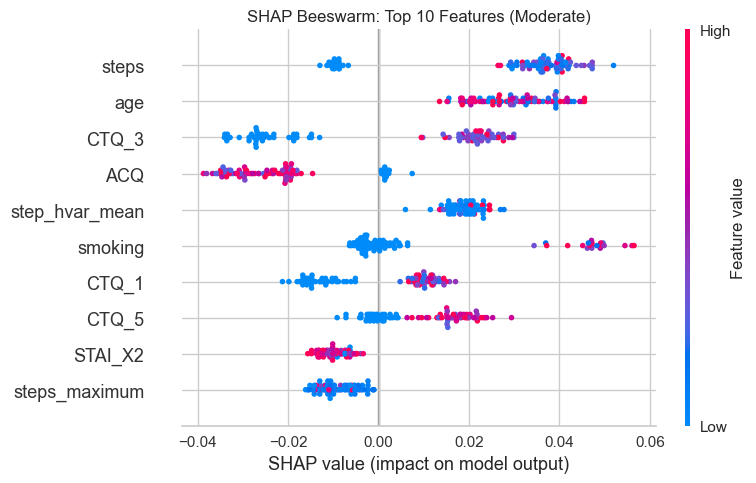

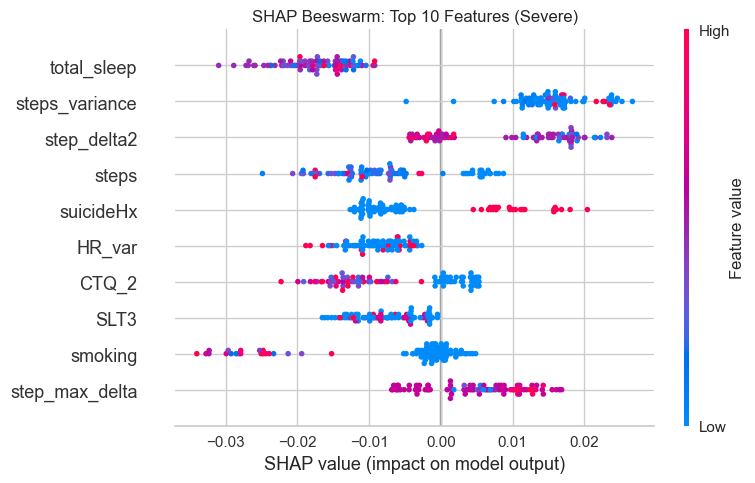

In [23]:
top_n = 10

for class_label, df in shap_dfs.items():
    # 1. Compute top N features by mean(|SHAP value|) for this class
    feature_importance = df.abs().mean(axis=0).sort_values(ascending=False)
    top_features = feature_importance.head(top_n).index.tolist()

    # 2. Subset SHAP values and features
    shap_values_top = df[top_features]
    X_top = X_holdout[top_features]

    # 3. Beeswarm plot (summary plot) for this class and top features only
    plt.figure(figsize=(8, 5))
    shap.summary_plot(
        shap_values_top.values,    # SHAP values: shape (n_samples, n_top_features)
        X_top,                    # Input features for those columns
        feature_names=top_features,
        show=False,               # So we can modify the plot
        plot_size=(8, 5)
    )
    plt.title(f"SHAP Beeswarm: Top {top_n} Features ({OUTPUT.plot_label2name[class_label]})")
    plt.tight_layout()
    plt.show()

# Notes

In [24]:
# Create a specific model (e.g., LightGBM)
# model = create_model('lightgbm')

# Tune the model hyperparameters
# tuned_model = tune_model(model, optimize='Accuracy')

# Ensemble models (optional)
# blended_model = blend_models([tuned_model, best_model])